In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [6]:
def data_definition():
    bike_sharing = fetch_ucirepo(id=275)
    print(bike_sharing.variables)
    return bike_sharing.data.features, bike_sharing.data.targets

In [7]:
def splitter(X, y):
    np.random.seed(42)
    selection = np.random.permutation(len(X))
    size = int(len(X) * 0.2)
    test_selection = selection[:size]
    train_selection = selection[size:]
    x_train, x_test = X.iloc[train_selection], X.iloc[test_selection]
    y_train, y_test = y.iloc[train_selection], y.iloc[test_selection]
    return x_train, x_test, y_train, y_test

          name     role         type demographic  \
0      instant       ID      Integer        None   
1       dteday  Feature         Date        None   
2       season  Feature  Categorical        None   
3           yr  Feature  Categorical        None   
4         mnth  Feature  Categorical        None   
5           hr  Feature  Categorical        None   
6      holiday  Feature       Binary        None   
7      weekday  Feature  Categorical        None   
8   workingday  Feature       Binary        None   
9   weathersit  Feature  Categorical        None   
10        temp  Feature   Continuous        None   
11       atemp  Feature   Continuous        None   
12         hum  Feature   Continuous        None   
13   windspeed  Feature   Continuous        None   
14      casual    Other      Integer        None   
15  registered    Other      Integer        None   
16         cnt   Target      Integer        None   

                                          description units mis

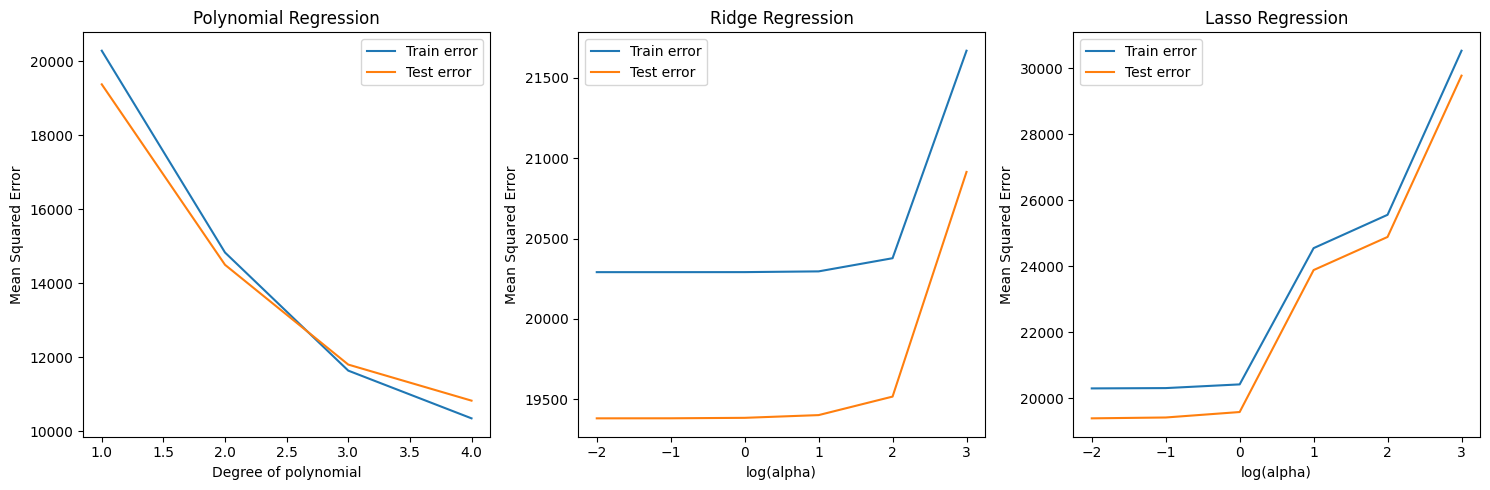

In [8]:
if __name__ == '__main__':
    # 1. Загрузка и подготовка данных
    x, y = data_definition()
    x['dteday'] = pd.to_datetime(x['dteday'])
    x['days_since_epoch'] = (x['dteday'] - pd.Timestamp('2011-01-01')) // pd.Timedelta('1D')
    x = x.drop(columns=['dteday'])
    x_train, x_test, y_train, y_test = splitter(x, y)

    # 2. Обучение базовой линейной регрессии
    regressor = LinearRegression().fit(x_train, y_train)
    
    # 3. Оценка базовой модели
    y_pred = regressor.predict(x_test)
    print("\nBase Linear Regression:")
    print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

    # 4. Полиномиальные признаки
    train_errors_poly = []
    test_errors_poly = []
    degrees = range(1, 5)

    for degree in degrees:
        polynom = PolynomialFeatures(degree=degree)
        x_train_poly = polynom.fit_transform(x_train)
        x_test_poly = polynom.transform(x_test)

        model = LinearRegression()
        model.fit(x_train_poly, y_train)

        y_train_pred = model.predict(x_train_poly)
        y_test_pred = model.predict(x_test_poly)

        train_errors_poly.append(mean_squared_error(y_train, y_train_pred))
        test_errors_poly.append(mean_squared_error(y_test, y_test_pred))

    # 5. Ridge и Lasso регрессия
    alphas = [0.01, 0.1, 1, 10, 100, 1000]
    
    ridge_train_errors = []
    ridge_test_errors = []
    
    lasso_train_errors = []
    lasso_test_errors = []

    for alpha in alphas:
        # Ridge
        ridge = Ridge(alpha=alpha)
        ridge.fit(x_train, y_train)
        ridge_train_pred = ridge.predict(x_train)
        ridge_test_pred = ridge.predict(x_test)
        ridge_train_errors.append(mean_squared_error(y_train, ridge_train_pred))
        ridge_test_errors.append(mean_squared_error(y_test, ridge_test_pred))
        
        # Lasso
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(x_train, y_train.values.ravel())
        lasso_train_pred = lasso.predict(x_train)
        lasso_test_pred = lasso.predict(x_test)
        lasso_train_errors.append(mean_squared_error(y_train, lasso_train_pred))
        lasso_test_errors.append(mean_squared_error(y_test, lasso_test_pred))

    # Сравнение лучших результатов
    best_poly_degree = np.argmin(test_errors_poly) + 1
    best_poly_error = test_errors_poly[best_poly_degree - 1]
    
    best_ridge_alpha = alphas[np.argmin(ridge_test_errors)]
    best_ridge_error = np.min(ridge_test_errors)
    
    best_lasso_alpha = alphas[np.argmin(lasso_test_errors)]
    best_lasso_error = np.min(lasso_test_errors)
    
    print("\nComparison of methods:")
    print(f"Best Polynomial (degree={best_poly_degree}): MSE = {best_poly_error:.2f}")
    print(f"Best Ridge (alpha={best_ridge_alpha}): MSE = {best_ridge_error:.2f}")
    print(f"Best Lasso (alpha={best_lasso_alpha}): MSE = {best_lasso_error:.2f}")
    
    # Определение лучшего метода
    methods = {
        'Polynomial': best_poly_error,
        'Ridge': best_ridge_error,
        'Lasso': best_lasso_error
    }
    best_method = min(methods, key=methods.get)
    print(f"\nThe best method is {best_method} with MSE = {methods[best_method]:.2f}")

    # Визуализация
    plt.figure(figsize=(15, 5))
    
    # Полиномиальная регрессия
    plt.subplot(1, 3, 1)
    plt.plot(degrees, train_errors_poly, label='Train error')
    plt.plot(degrees, test_errors_poly, label='Test error')
    plt.xlabel('Degree of polynomial')
    plt.ylabel('Mean Squared Error')
    plt.title('Polynomial Regression')
    plt.legend()
    
    # Ridge регрессия
    plt.subplot(1, 3, 2)
    plt.plot(np.log10(alphas), ridge_train_errors, label='Train error')
    plt.plot(np.log10(alphas), ridge_test_errors, label='Test error')
    plt.xlabel('log(alpha)')
    plt.ylabel('Mean Squared Error')
    plt.title('Ridge Regression')
    plt.legend()
    
    # Lasso регрессия
    plt.subplot(1, 3, 3)
    plt.plot(np.log10(alphas), lasso_train_errors, label='Train error')
    plt.plot(np.log10(alphas), lasso_test_errors, label='Test error')
    plt.xlabel('log(alpha)')
    plt.ylabel('Mean Squared Error')
    plt.title('Lasso Regression')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
